## Run FFPer on simulated time-series with one injected planet and check if recovered correctly


In [19]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

In [20]:
import sys
sys.path.append('../')
from ffper import extract_activity_basis, construct_basis, fit_basis, run_l1_periodogram

In [21]:
from glob import glob
from os.path import basename
from scipy.io import readsav, loadmat
import time

In [22]:
data_root = '/Users/aigrain/Data/meunier2024/blind/data/'
par_file = data_root + 'params_injected_G2.txt'
par_inj = np.genfromtxt(par_file).T
per_inj = par_inj[3]
amp_inj = par_inj[4]
pha_inj = par_inj[5]
NFL = len(per_inj)
print(NFL)


813


In [18]:
root_in = data_root + 'my_serie_res_bt_G2_1000_4m_NOISE0.09_OGS_MAG_real'

fls = glob(root_in + '*.mat')
NFL = len(fls)
NFL = 10

S_MAX = 3
WN = 0.3 # White noise to add to data to make it HARPS3-like

outfl = data_root + f'G2_suz_inj_GdG_L1_S{S_MAX:d}.txt'
hdr = f"{'#ID':3s} {'Pcyc':7s} {'Prot':6s} {'Pinj':8s} {'Pdet':8s} {'Ainj':6s}"
hdr += f" {'Adet':6s} {'Phinj':7s} {'Phdet':7s} {'log10FAP':10s}"
with open(outfl, 'w') as f:
    f.write(hdr + "\n")
print(hdr)

for i in range(NFL):
    fl = root_in + f'{i:d}.mat'
    
    d = loadmat(fl)
    x = np.array(d['tt']).flatten()
    y = np.array(d['rv']).flatten()
    z = np.array(d['ca']).flatten()

    y += np.random.normal(0, WN, len(y))
    
    y_sig = np.zeros_like(y) + np.sqrt(0.09**2 + WN**2) # see M+23, section 2.1.3
    z_sig = np.zeros_like(z) + 5e-4 # see M+23, section 2.1.3
    s = np.floor((x-min(x)+30) / 365).astype(int)

    l = s < S_MAX
    x = x[l]
    y = y[l]    
    y_sig = y_sig[l]
    z = z[l]
    z_sig = z_sig[l]
    s = s[l]
    
    # extract activity basis
    activity_terms, activity_periods, GP_par, activity_figures = \
        extract_activity_basis(x, z, zerr = z_sig,
                               do_plot = True, verbose = False)
    save_name = fl.replace('.mat',f'_FFPer_S{S_MAX:d}')
    plt.figure(activity_figures[0].number)
    plt.savefig(save_name + '_activity_LSper.png')
    plt.figure(activity_figures[1].number)
    plt.savefig(save_name + '_activity_GdG.png')
    plt.figure(activity_figures[2].number)
    plt.savefig(save_name + '_activity_fit.png')
    
    # Run L1 periodogram, including activity basis set as unpenalised vectors
    Basis = construct_basis(x, activity_terms)
    periods, faps = run_l1_periodogram(x, y, s, y_sig, basis = Basis, 
                                       sig_add_w = 0.0, fap_threshold = 1.0, 
                                       n_pk_eval_max = 1)

    # Add newly found periods to basis and perform fit again

    # Fit RVs again including new candidate planet and activity basis vectors
    Basis = construct_basis(x, activity_terms, [], periods)
    resid, coeff, fit_figure = fit_basis(x, y, y_sig, Basis, 
                                         do_plot = True, verbose = False)

    # Add newly vertical lines to periodogram in last figure and save it
    per_cyc, per_rot = activity_periods
    plt.figure(fit_figure.number)
    plt.sca(plt.gcf().axes[0])
    plt.axvline(periods[0], color = 'C2', ls = 'dashed', alpha = 0.5)
    plt.axvline(per_rot, color = 'C0', ls = 'dashed', alpha = 0.5)
    plt.axvline(per_rot/2, color = 'C0', ls = 'dashed', alpha = 0.5)
    if per_cyc>0:
        plt.axvline(per_cyc, color = 'C0', ls = 'dotted', alpha = 0.5)
    plt.axvline(per_inj[i], color = 'C3', ls = 'dotted', alpha = 0.5)
    plt.savefig(save_name + '_RV_fit.png')

    amp = np.sqrt(coeff[4]**2 + coeff[5]**2) 
    pha = np.arctan2(coeff[4], coeff[5]) / np.pi /2  # needs fixing!
    if pha < 0:
        pha += 1
    lin = f"{i:3d} {per_cyc:7.1f} {per_rot:6.2f} {per_inj[i]:8.3f} {periods[0]:8.3f} "
    lin += f"{amp_inj[i]:6.2f} {amp:6.2f} {pha_inj[i]:7.2f} {pha:7.2f} {faps[0]:10.2e}"
    with open(outfl, 'a') as f:
        f.write(lin + "\n")
    print(lin)

    plt.close('all')
    

#ID Pcyc    Prot   Pinj     Pdet     Ainj   Adet   Phinj   Phdet   log10FAP  
  0    -1.0  22.82  365.650  373.069   0.79   0.72    0.24    0.16  -4.92e+00
  1    -1.0  14.64  352.800  325.343   0.53   0.70    0.25    0.35  -1.15e+01
  2    -1.0  18.66  426.740    1.101   0.11   0.21    0.27    0.61  -4.86e-01
  3    -1.0  20.59   70.320   70.432   0.46   0.42    0.96    0.09  -8.01e+00
  4    -1.0  21.34   28.030   28.063   0.96   1.03    0.30    0.18  -2.39e+01
  5    -1.0  20.79  305.970  305.972   0.62   0.71    0.90    0.12  -5.57e+00
  6    -1.0  23.50  238.610  244.200   0.56   0.46    0.53    0.11  -6.38e+00
  7    -1.0  20.41  322.030  305.284   0.69   0.50    0.51    0.44  -2.59e+00
  8    -1.0  17.68  269.470  270.783   0.59   0.59    0.46    0.13  -1.07e+01
  9    -1.0  26.07  388.420  406.954   0.83   0.85    0.43    0.00  -3.86e+01


In [24]:
fl1 = outfl = data_root + 'G2_suz_inj_GdG_L1_S4.txt'
X1 = np.genfromtxt(fl1).T
ID, Pcyc, Prot, Pinj, Pdet1, Ainj, Adet1, Phinj, Phdet1, log10FAP1 = X1
Prat1 = Pdet1/Pinj
good1 = (Prat1 >= 0.95) * ( Prat1 <= 1.05)
print(good1.sum()/len(good1))

0.5953259532595326


In [25]:
fl2 = outfl = data_root + 'G2_suz_inj_GdG_L1_S10.txt'
X2 = np.genfromtxt(fl2).T
ID, Pcyc, Prot, Pinj, Pdet2, Ainj, Adet2, Phinj, Phdet2, log10FAP2 = X2
Prat2 = Pdet2/Pinj
good2 = (Prat2 >= 0.95) * ( Prat2 <= 1.05)
print(good2.sum()/len(good2))

0.7539975399753998


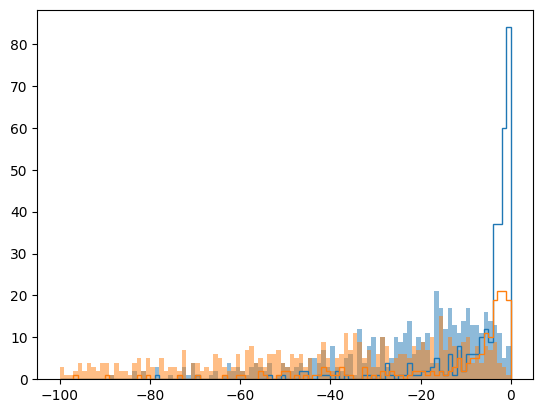

In [26]:
plt.hist(log10FAP1[good1],range=(-100,0),bins=100,alpha=0.5,histtype='stepfilled',color = 'C0')
plt.hist(log10FAP1[~good1],range=(-100,0),bins=100,histtype='step',color = 'C0')
plt.hist(log10FAP2[good2],range=(-100,0),bins=100,alpha=0.5,histtype='stepfilled',color = 'C1')
plt.hist(log10FAP2[~good2],range=(-100,0),bins=100,histtype='step',color = 'C1');


[0.1        0.5        0.89655172 1.         1.        ]
[0.         0.55172414 0.875      0.96774194 0.975     ]
[0.         0.5        0.91176471 0.96428571 0.97222222]
[0.07142857 0.39393939 0.83333333 0.90909091 1.        ]
[0.07692308 0.53333333 0.72413793 0.96774194 1.        ]
[0.09090909 0.60714286 0.75757576 0.96875    1.        ]


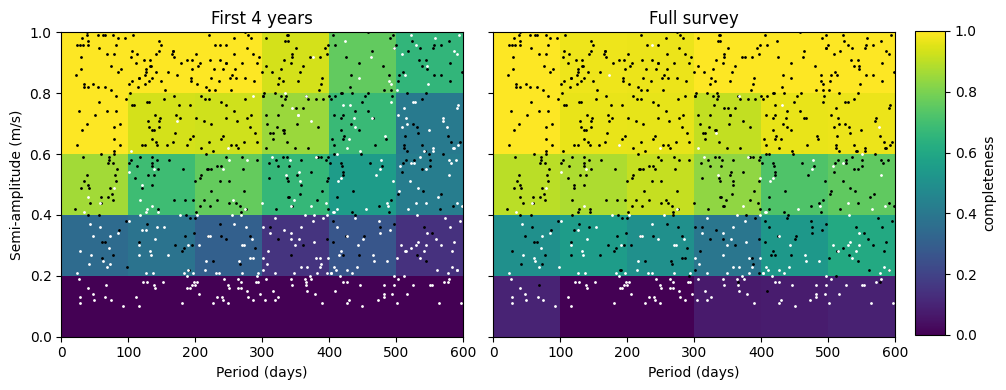

In [27]:

grid_per = np.array(range(7)) * 100
grid_amp = np.array(range(6)) * 0.2
compl4 = np.zeros((len(grid_per)-1,len(grid_amp)-1)) + np.nan
compl10 = np.zeros((len(grid_per)-1,len(grid_amp)-1)) + np.nan
for i in range(len(grid_per)-1):
    for j in range(len(grid_amp)-1):
        l = (Pinj >= grid_per[i]) * (Pinj < grid_per[i+1]) * (Ainj >= grid_amp[j]) * (Ainj < grid_amp[j+1]) 
        n = l.sum()
        ldet1 = l * good1
        ndet1 = ldet1.sum()
        compl4[i,j] = ndet1/n
        ldet2 = l * good2
        ndet2 = ldet2.sum()
        compl10[i,j] = ndet2/n
    # print(compl4[i,:])
    print(compl10[i,:])

fig, ax = plt.subplots(figsize = (10,4), nrows=1, ncols=2,sharex=True, sharey = True)

ax[0].imshow(compl4.T,interpolation = 'nearest',extent=(0,600,0,1.0),
             origin='lower',aspect='auto')
ax[0].plot(Pinj[good1],Ainj[good1],'k.',ms=2)
ax[0].plot(Pinj[~good1],Ainj[~good1],'w.',ms=2)
ax[0].set_xlabel('Period (days)')
ax[0].set_ylabel('Semi-amplitude (m/s)')
ax[0].set_title('First 4 years')

im = ax[1].imshow(compl10.T,interpolation = 'nearest',extent=(0,600,0,1.0),
                  origin='lower',aspect='auto')
ax[1].plot(Pinj[good2],Ainj[good2],'k.',ms=2)
ax[1].plot(Pinj[~good2],Ainj[~good2],'w.',ms=2)
ax[1].set_xlabel('Period (days)')
ax[1].set_title('Full survey')

plt.tight_layout()

fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.92, 0.15, 0.03, 0.76])
cb = fig.colorbar(im, cax=cbar_ax)
cb.set_label('completeness')
plt.savefig('completeness.png');

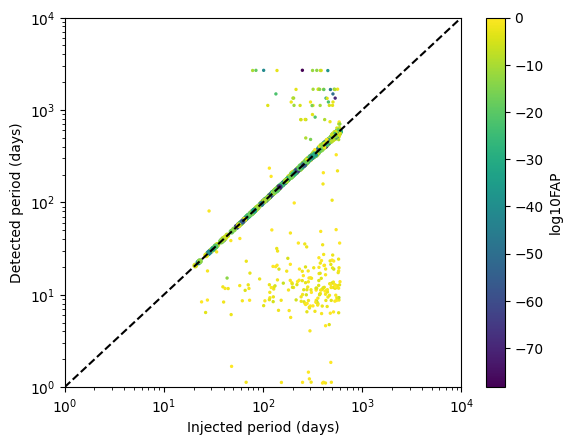

In [29]:
plt.plot([1,10000],[1,10000], 'k--')
plt.scatter(Pinj[good1], Pdet1[good1], c = log10FAP1[good1], s=10)
plt.scatter(Pinj[~good1], Pdet1[~good1], c = log10FAP1[~good1], s=2)
plt.loglog()
plt.xlim(1,10000)
plt.ylim(1,10000)
plt.xlabel('Injected period (days)')
plt.ylabel('Detected period (days)')
cb = plt.colorbar()
cb.set_label('log10FAP')

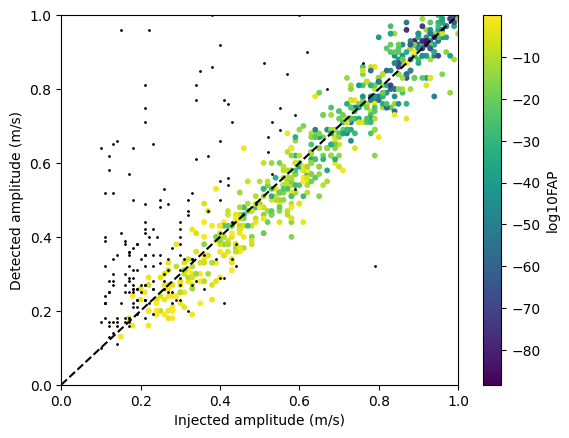

In [30]:
plt.plot([0,10],[0,10], 'k--')
plt.plot(Ainj[~good2], Adet2[~good2], 'k.', ms=2)
plt.scatter(Ainj[good2], Adet2[good2], c = log10FAP1[good2], s=10)
plt.xlim(0.0,1.0)
plt.ylim(0.0,1.0)
plt.xlabel('Injected amplitude (m/s)')
plt.ylabel('Detected amplitude (m/s)')
cb = plt.colorbar()
cb.set_label('log10FAP')
plt.savefig('amplitude_10yrs')

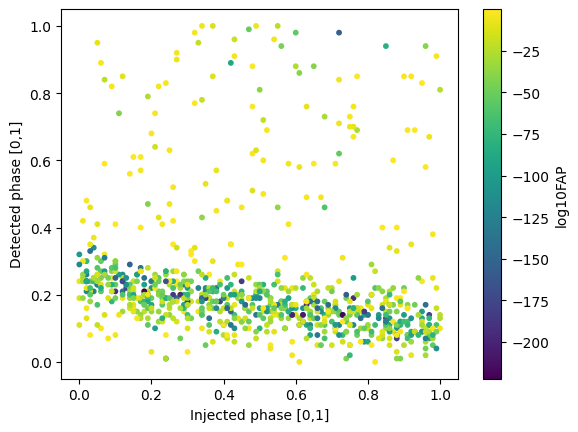

In [35]:
# plt.plot([0,10],[0,10], 'k--')
plt.scatter(Phinj, Phdet2, c = log10FAP2, s=10)
# plt.xlim(0.0,1.0)
# plt.ylim(0.0,1.0)
plt.xlabel('Injected phase [0,1]')
plt.ylabel('Detected phase [0,1]')
cb = plt.colorbar()
cb.set_label('log10FAP')